In [1]:
install.packages("tidyverse")
install.packages("fastDummies")
install.packages("dbscan")
install.packages("mclust")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
library("ggplot2")
library("dplyr")
library("fastDummies")
library("cluster")
library("dbscan")
library("mclust")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Thank you for using fastDummies!

To acknowledge our work, please cite the package:

Kaplan, J. & Schlegel, B. (2023). fastDummies: Fast Creation of Dummy (Binary) Columns and Rows from Categorical Variables. Version 1.7.1. URL: https://github.com/jacobkap/fastDummies, https://jacobkap.github.io/fastDummies/.


Attaching package: ‘dbscan’


The following object is masked from ‘package:stats’:

    as.dendrogram


Package 'mclust' version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



In [3]:
url <- "https://archive.ics.uci.edu/static/public/2/adult.zip"
destfile <- "adult.zip"

download.file(url, destfile)

In [4]:
unzip(destfile, exdir = "adult_data")

In [5]:
list.files("adult_data")

[1] "adult.data"      "adult.names"     "adult.test"      "Index"          
[5] "old.adult.names"

In [91]:
file_path <- file.path("adult_data", "adult.data")

df <- read.csv(file_path, header = FALSE)
df <- as.data.frame(df)

head(df)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15
,<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>
1,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
2,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
3,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
4,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
5,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
6,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


# Preprocessing The Dataframe

In [92]:
names(df)

[1] "V1"  "V2"  "V3"  "V4"  "V5"  "V6"  "V7"  "V8"  "V9"  "V10" "V11" "V12"
[13] "V13" "V14" "V15"

In [93]:
names_path <- file.path("adult_data", "adult.names")
names_content <- readLines(names_path)

names_content

[1] "| This data was extracted from the census bureau database found at"                                                                                                                                                                                                                                                                                                                                                                             
  [2] "| http://www.census.gov/ftp/pub/DES/www/welcome.html"                                                                                                                                                                                                                                                                                                                                                                                           
  [3] "| Donor: Ronny Kohavi and Barry Becker,"                                                                                                                                                                                                                                                                                                                                                                                                        
  [4] "|        Data Mining and Visualization"                                                                                                                                                                                                                                                                                                                                                                                                         
  [5] "|        Silicon Graphics."                                                                                                                                                                                                                                                                                                                                                                                                                     
  [6] "|        e-mail: ronnyk@sgi.com for questions."                                                                                                                                                                                                                                                                                                                                                                                                 
  [7] "| Split into train-test using MLC++ GenCVFiles (2/3, 1/3 random)."                                                                                                                                                                                                                                                                                                                                                                              
  [8] "| 48842 instances, mix of continuous and discrete    (train=32561, test=16281)"                                                                                                                                                                                                                                                                                                                                                                 
  [9] "| 45222 if instances with unknown values are removed (train=30162, test=15060)"                                                                                                                                                                                                                                                                                                                                                                 
 [10] "| Duplicate or conflicting instance

In [94]:
# Find the start index for the attributes section
start_index <- grep("^[^|]", names_content)
start_index <- start_index[2]  # The second match is where attributes start

# Extract and clean the column names
column_lines <- names_content[start_index:(start_index + 13)]  # There are 14 attributes
column_names <- sub(":.*", "", column_lines)
column_names <- gsub(" ", "_", column_names)  # Replace spaces with underscores

# Add the 'income' column manually
column_names <- c(column_names, "income")

# Display the column names
column_names

[1] "age"            "workclass"      "fnlwgt"         "education"     
 [5] "education-num"  "marital-status" "occupation"     "relationship"  
 [9] "race"           "sex"            "capital-gain"   "capital-loss"  
[13] "hours-per-week" "native-country" "income"

In [95]:
length(column_names)
length(names(df))

cat("Correctly extracted names: ", length(column_names)==length(names(df)))

[1] 15

[1] 15

Correctly extracted names:  TRUE

In [96]:
colnames(df) <- column_names

df

age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>
39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K


In [97]:
dim(df)

[1] 32561    15

In [98]:
# Number of rows we will use
sample_size <- 2500

# Get a random sample of row indices
sample_indices <- sample(1:nrow(df), sample_size)

# Subset the data frame using the random indices
df <- df[sample_indices, ]

df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
,<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>
12277,21,Private,180339,Assoc-voc,11,Never-married,Farming-fishing,Not-in-family,White,Female,0,1602,30,United-States,<=50K
28275,24,Private,130741,Bachelors,13,Never-married,Sales,Own-child,White,Male,0,0,40,United-States,<=50K
30409,33,Private,225507,10th,6,Never-married,Other-service,Own-child,White,Female,0,0,25,United-States,<=50K
28564,42,Self-emp-inc,348886,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
5328,52,Private,145548,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
17222,27,Self-emp-inc,114158,Bachelors,13,Never-married,Exec-managerial,Own-child,White,Female,0,0,40,United-States,<=50K
28478,28,Private,42881,10th,6,Divorced,Machine-op-inspct,Own-child,White,Female,0,0,40,United-States,<=50K
7165,20,?,201766,Some-college,10,Never-married,?,Own-child,White,Female,0,0,35,United-States,<=50K
28255,25,Private,44861,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [99]:
dim(df)

cat("Number of rows:", nrow(df), "\n")
cat("Number of columns:", ncol(df), "\n")

[1] 2500   15

Number of rows: 2500 
Number of columns: 15 


In [100]:
sum(is.na(df))

[1] 0

In [101]:
df <- df %>% mutate(across(where(is.character), trimws))

df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
,<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>
12277,21,Private,180339,Assoc-voc,11,Never-married,Farming-fishing,Not-in-family,White,Female,0,1602,30,United-States,<=50K
28275,24,Private,130741,Bachelors,13,Never-married,Sales,Own-child,White,Male,0,0,40,United-States,<=50K
30409,33,Private,225507,10th,6,Never-married,Other-service,Own-child,White,Female,0,0,25,United-States,<=50K
28564,42,Self-emp-inc,348886,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
5328,52,Private,145548,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
17222,27,Self-emp-inc,114158,Bachelors,13,Never-married,Exec-managerial,Own-child,White,Female,0,0,40,United-States,<=50K
28478,28,Private,42881,10th,6,Divorced,Machine-op-inspct,Own-child,White,Female,0,0,40,United-States,<=50K
7165,20,?,201766,Some-college,10,Never-married,?,Own-child,White,Female,0,0,35,United-States,<=50K
28255,25,Private,44861,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [102]:
total_unknown <- sum(df == "?")
total_unknown_rows <- sum(apply(df, 1, function(row) any(row == "?")))
cat(paste("Total '?' values in the dataframe:", total_unknown))
cat(paste("\nTotal rows with '?' values in the dataframe:", total_unknown_rows))

Total '?' values in the dataframe: 352
Total rows with '?' values in the dataframe: 197

In [103]:
df[df == "?"] <- NA

df <- na.omit(df)
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
,<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>
12277,21,Private,180339,Assoc-voc,11,Never-married,Farming-fishing,Not-in-family,White,Female,0,1602,30,United-States,<=50K
28275,24,Private,130741,Bachelors,13,Never-married,Sales,Own-child,White,Male,0,0,40,United-States,<=50K
30409,33,Private,225507,10th,6,Never-married,Other-service,Own-child,White,Female,0,0,25,United-States,<=50K
28564,42,Self-emp-inc,348886,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
5328,52,Private,145548,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
17222,27,Self-emp-inc,114158,Bachelors,13,Never-married,Exec-managerial,Own-child,White,Female,0,0,40,United-States,<=50K
28478,28,Private,42881,10th,6,Divorced,Machine-op-inspct,Own-child,White,Female,0,0,40,United-States,<=50K
28255,25,Private,44861,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,40,United-States,<=50K
18303,32,Private,316470,5th-6th,3,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,60,Mexico,<=50K


In [104]:
dim(df)

[1] 2303   15

In [105]:
categorical <-df %>% select_if(is.character)

categorical

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
12277,Private,Assoc-voc,Never-married,Farming-fishing,Not-in-family,White,Female,United-States,<=50K
28275,Private,Bachelors,Never-married,Sales,Own-child,White,Male,United-States,<=50K
30409,Private,10th,Never-married,Other-service,Own-child,White,Female,United-States,<=50K
28564,Self-emp-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,>50K
5328,Private,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,United-States,>50K
17222,Self-emp-inc,Bachelors,Never-married,Exec-managerial,Own-child,White,Female,United-States,<=50K
28478,Private,10th,Divorced,Machine-op-inspct,Own-child,White,Female,United-States,<=50K
28255,Private,HS-grad,Never-married,Other-service,Not-in-family,White,Male,United-States,<=50K
18303,Private,5th-6th,Married-civ-spouse,Craft-repair,Husband,White,Male,Mexico,<=50K


In [106]:
one_hot_encoded <- dummy_cols(categorical, remove_first_dummy = TRUE)

one_hot_encoded

workclass,education,marital-status,occupation,relationship,race,sex,native-country,income,workclass_Local-gov,⋯,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_South,native-country_Taiwan,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,income_>50K
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Private,Assoc-voc,Never-married,Farming-fishing,Not-in-family,White,Female,United-States,<=50K,0,⋯,0,0,0,0,0,0,1,0,0,0
Private,Bachelors,Never-married,Sales,Own-child,White,Male,United-States,<=50K,0,⋯,0,0,0,0,0,0,1,0,0,0
Private,10th,Never-married,Other-service,Own-child,White,Female,United-States,<=50K,0,⋯,0,0,0,0,0,0,1,0,0,0
Self-emp-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,>50K,0,⋯,0,0,0,0,0,0,1,0,0,1
Private,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,United-States,>50K,0,⋯,0,0,0,0,0,0,1,0,0,1
Self-emp-inc,Bachelors,Never-married,Exec-managerial,Own-child,White,Female,United-States,<=50K,0,⋯,0,0,0,0,0,0,1,0,0,0
Private,10th,Divorced,Machine-op-inspct,Own-child,White,Female,United-States,<=50K,0,⋯,0,0,0,0,0,0,1,0,0,0
Private,HS-grad,Never-married,Other-service,Not-in-family,White,Male,United-States,<=50K,0,⋯,0,0,0,0,0,0,1,0,0,0
Private,5th-6th,Married-civ-spouse,Craft-repair,Husband,White,Male,Mexico,<=50K,0,⋯,0,0,0,0,0,0,0,0,0,0


In [107]:
cols_to_remove <- ncol(categorical)

# Remove the first few columns
one_hot_encoded <- one_hot_encoded[, (cols_to_remove + 1):ncol(one_hot_encoded)]
one_hot_encoded

workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_5th-6th,education_7th-8th,education_9th,education_10th,⋯,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_South,native-country_Taiwan,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,income_>50K
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0,0
0,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0,0
0,1,0,0,0,0,0,0,0,1,⋯,0,0,0,0,0,0,1,0,0,0
0,0,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0,1
0,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0,1
0,0,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0,0
0,1,0,0,0,0,0,0,0,1,⋯,0,0,0,0,0,0,1,0,0,0
0,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0,0
0,1,0,0,0,0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


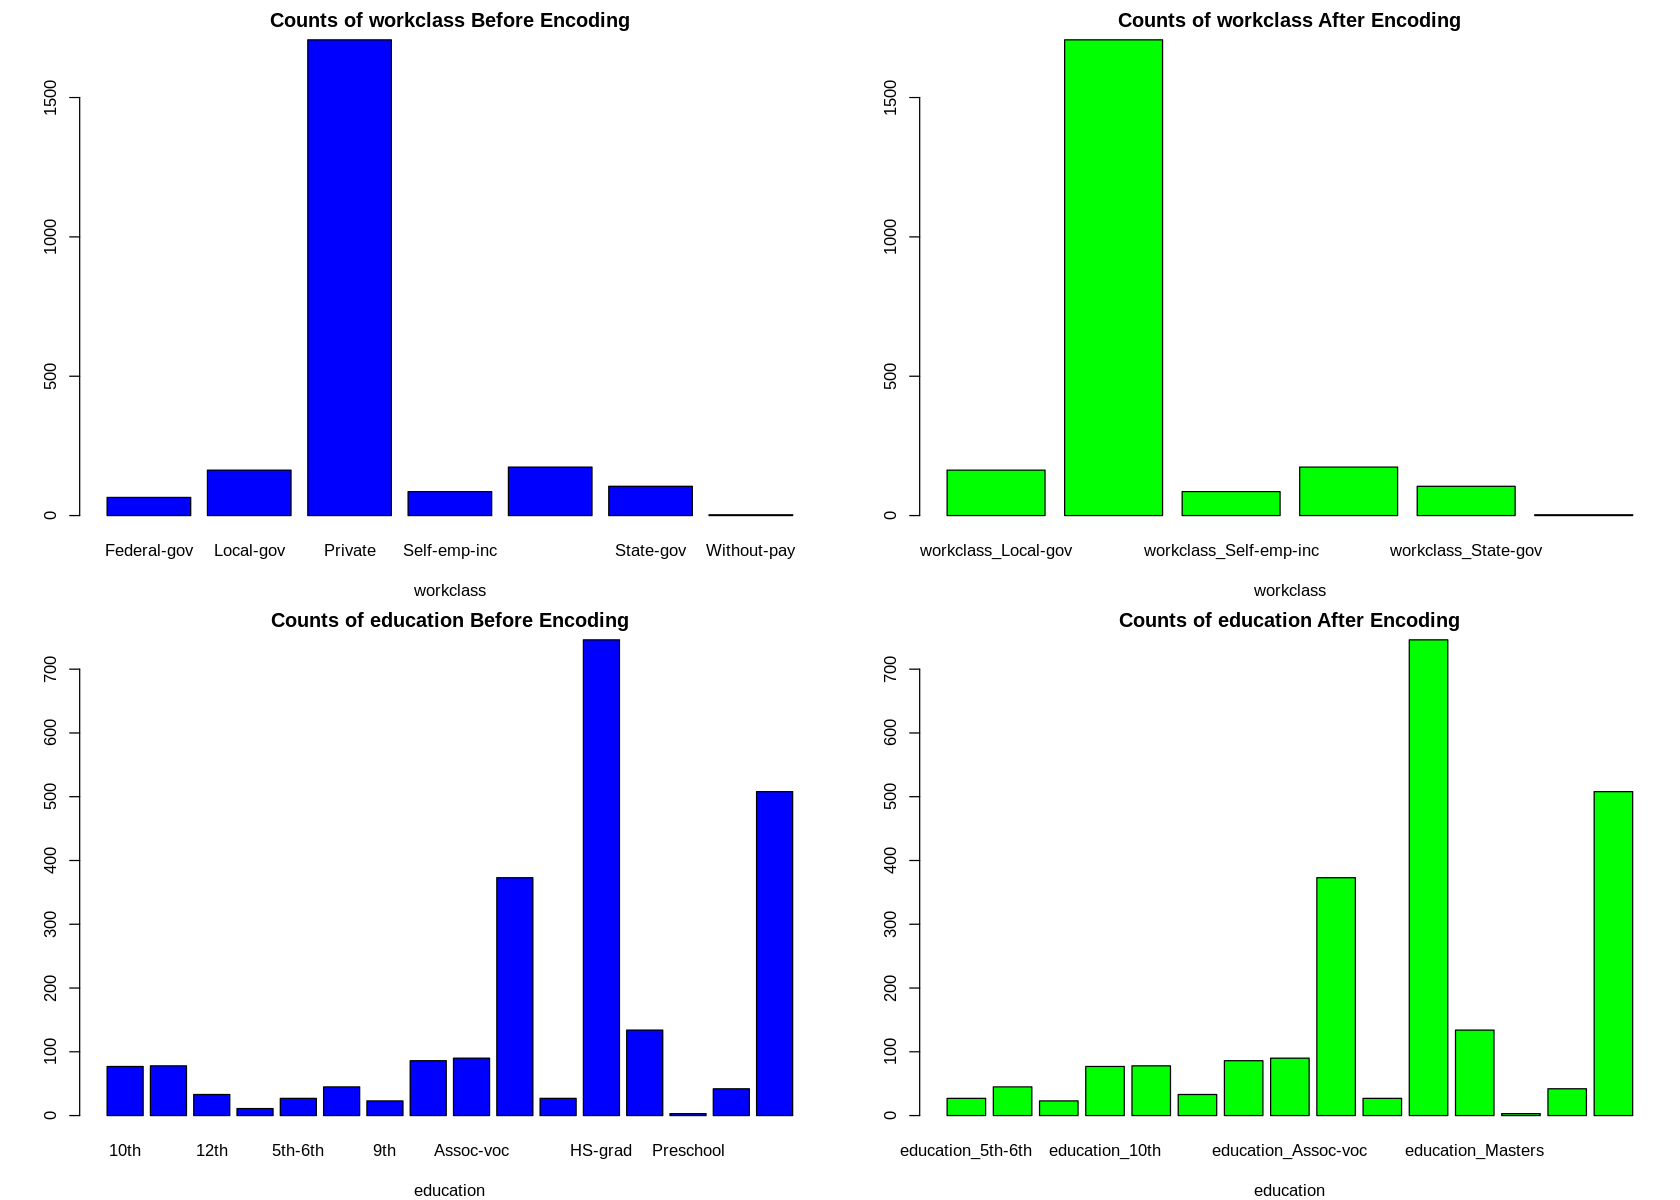

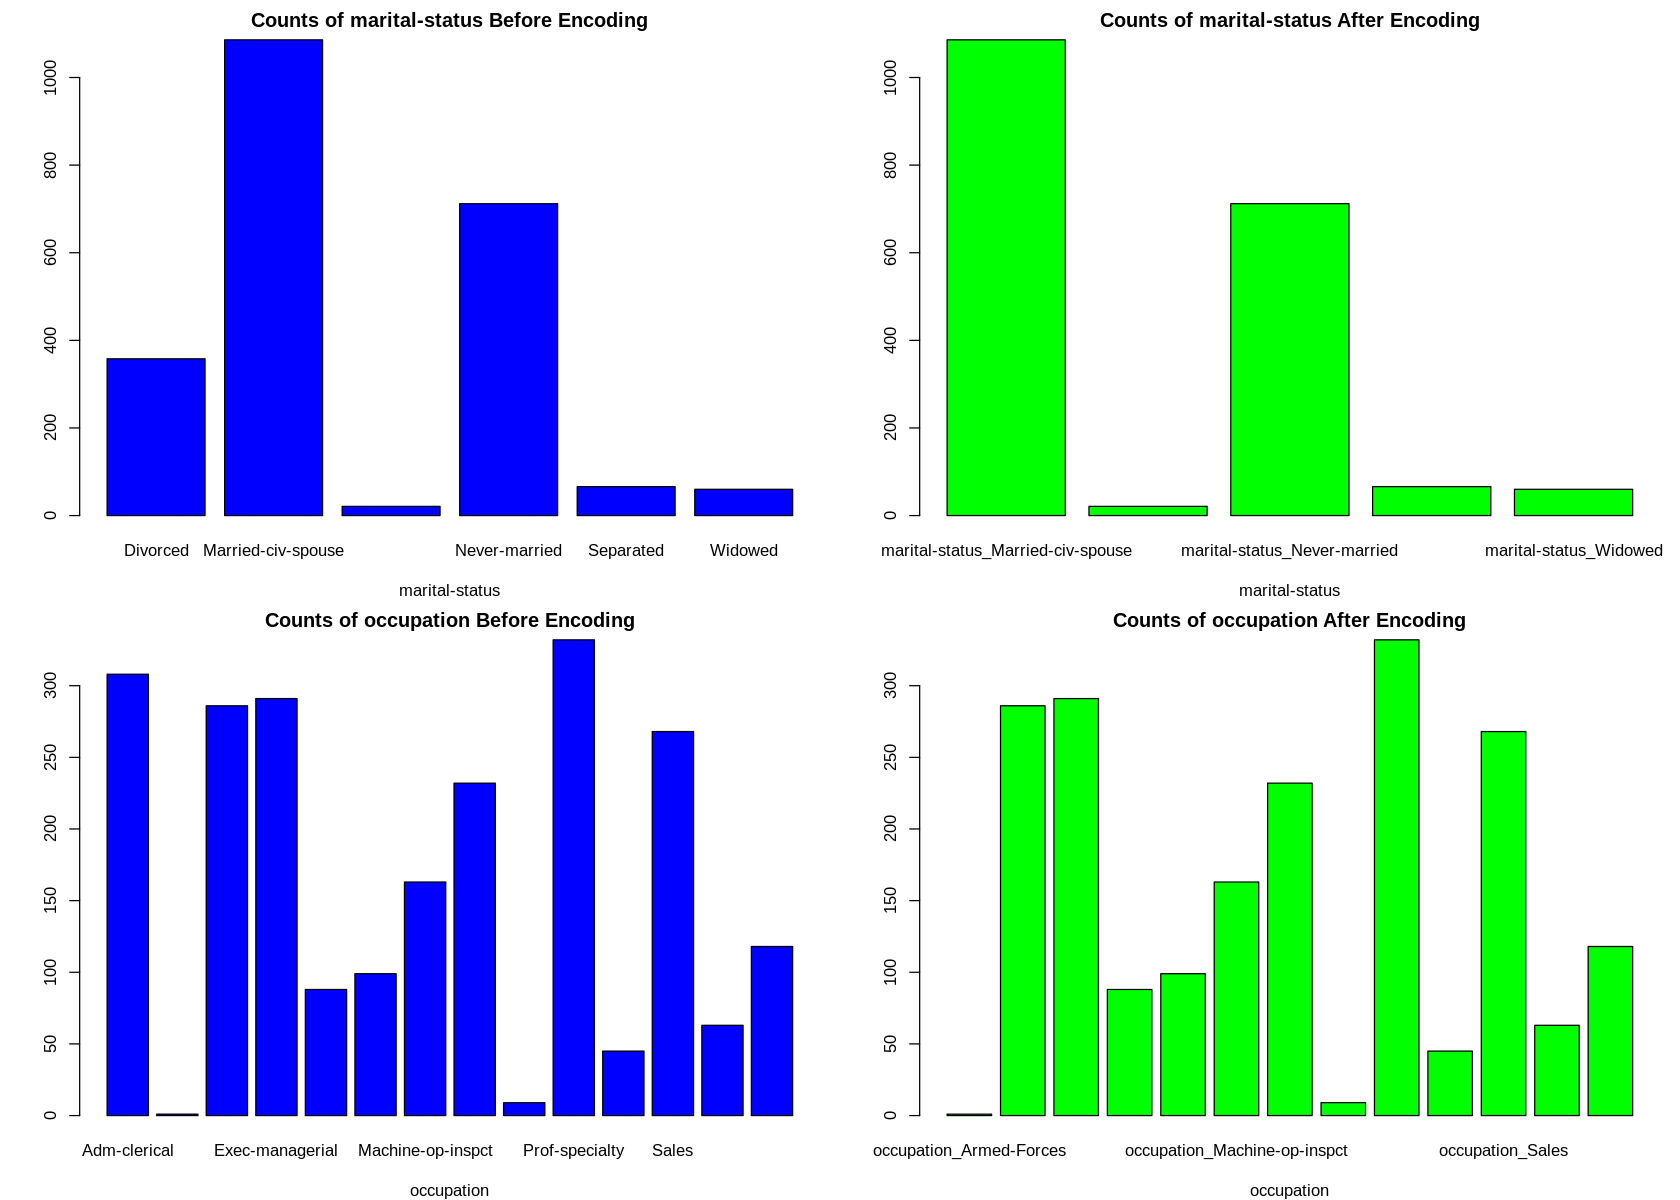

In [108]:
# Select a subset of categorical columns for demonstration
demo_cat_cols <- names(categorical)[1:4]  # Adjust the number of columns as needed

# Set up the plotting area
options(repr.plot.width = 14, repr.plot.height = 10)  # Increase plot area size
num_plots <- length(demo_cat_cols)
num_rows <- ceiling(num_plots / 2)

# Set up the plotting area for before and after encoding histograms
par(mfrow = c(num_rows, 2), mar = c(4, 4, 2, 1))

# Plot counts before and after one-hot encoding for each selected categorical variable
for (col in demo_cat_cols) {
  # Count the frequency of each category
  cat_counts <- table(categorical[[col]])
  barplot(cat_counts, main = paste("Counts of", col, "Before Encoding"), col = "blue", xlab = col)

  # Plot the one-hot encoded columns corresponding to the original column
  one_hot_cols <- grep(paste0("^", col, "_"), names(one_hot_encoded), value = TRUE)

  # Summarize the one-hot encoded columns
  one_hot_sums <- colSums(one_hot_encoded[one_hot_cols])

  barplot(one_hot_sums, main = paste("Counts of", col, "After Encoding"), col = "green", xlab = col)
}

# Reset par settings to default
par(mfrow = c(1, 1))

In [109]:
numerical <-df %>% select_if(is.numeric)

numerical

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
,<int>,<int>,<int>,<int>,<int>,<int>
12277,21,180339,11,0,1602,30
28275,24,130741,13,0,0,40
30409,33,225507,6,0,0,25
28564,42,348886,13,0,0,45
5328,52,145548,12,0,0,40
17222,27,114158,13,0,0,40
28478,28,42881,6,0,0,40
28255,25,44861,9,0,0,40
18303,32,316470,3,0,0,60


In [110]:
#function to scale data from a range of 0-1 (0 being minimum, 1 being maximum)
min_max_scaler <- function(x) {
  return ((x - min(x)) / (max(x) - min(x)))
}

In [111]:
scaled_numerical <- as.data.frame(lapply(numerical, min_max_scaler))
names(scaled_numerical)

scaled_numerical

[1] "age"            "fnlwgt"         "education.num"  "capital.gain"  
[5] "capital.loss"   "hours.per.week"

age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.05479452,0.10961922,0.6666667,0,0.4107692,0.28865979
0.09589041,0.07576284,0.8000000,0,0.0000000,0.39175258
0.21917808,0.14045160,0.3333333,0,0.0000000,0.23711340
0.34246575,0.22467205,0.8000000,0,0.0000000,0.44329897
0.47945205,0.08587033,0.7333333,0,0.0000000,0.39175258
0.13698630,0.06444302,0.8000000,0,0.0000000,0.39175258
0.15068493,0.01578822,0.3333333,0,0.0000000,0.39175258
0.10958904,0.01713980,0.5333333,0,0.0000000,0.39175258
0.20547945,0.20254438,0.1333333,0,0.0000000,0.59793814


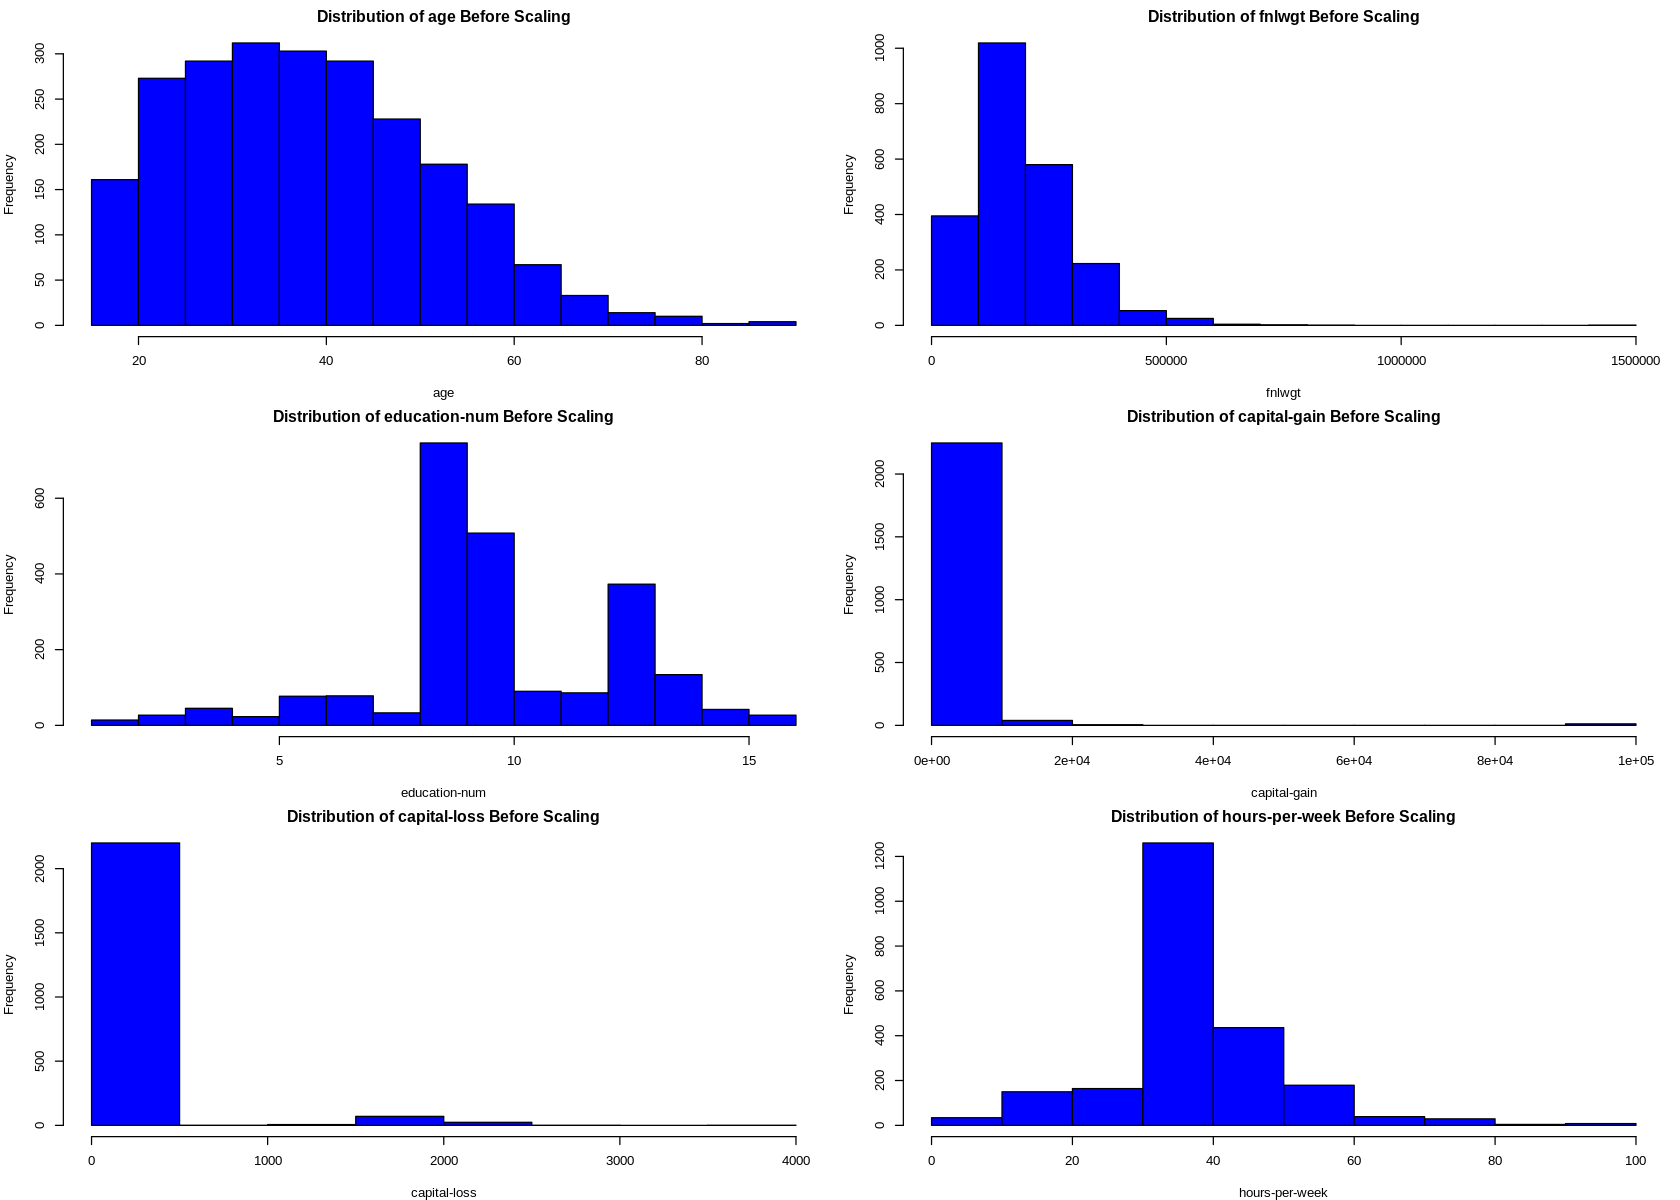

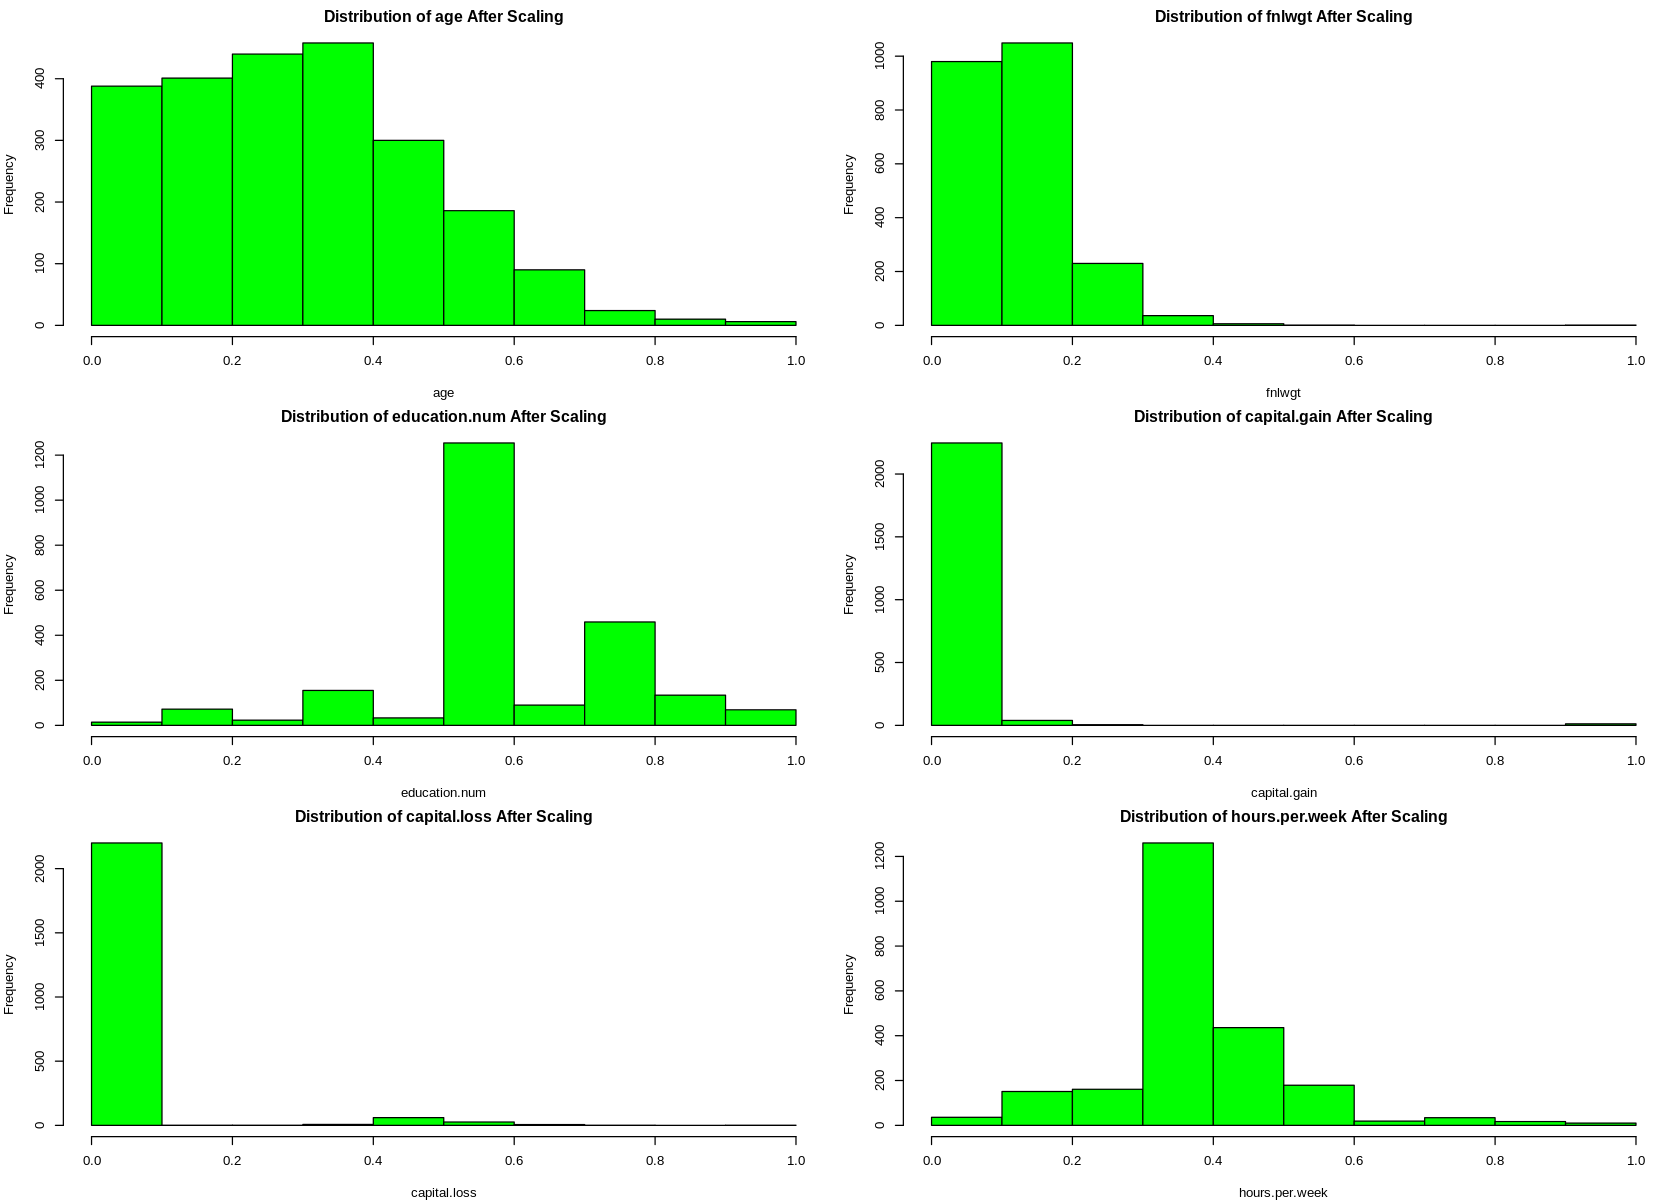

In [112]:
# Calculate the number of rows needed for the plots
num_plots <- length(names(numerical))
num_rows <- ceiling(num_plots / 2)

# Set up the plotting area for before scaling histograms
par(mfrow = c(num_rows, 2), mar = c(4, 4, 2, 1))

# Plot distributions before scaling for numerical features
for (col in names(numerical)) {
  hist(numerical[[col]], main = paste("Distribution of", col, "Before Scaling"), col = "blue", xlab = col)
}

# Set up the plotting area for after scaling histograms
par(mfrow = c(num_rows, 2), mar = c(4, 4, 2, 1))

# Plot distributions after scaling for numerical features
for (col in names(scaled_numerical)) {
  hist(scaled_numerical[[col]], main = paste("Distribution of", col, "After Scaling"), col = "green", xlab = col)
}

# Reset par settings to default
par(mfrow = c(1, 1))

In [113]:
df_preprocessed <- cbind(one_hot_encoded, scaled_numerical)

df_preprocessed

workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_5th-6th,education_7th-8th,education_9th,education_10th,⋯,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,income_>50K,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,1,0,0,0,0,0,0,0,0,⋯,1,0,0,0,0.05479452,0.10961922,0.6666667,0,0.4107692,0.28865979
0,1,0,0,0,0,0,0,0,0,⋯,1,0,0,0,0.09589041,0.07576284,0.8000000,0,0.0000000,0.39175258
0,1,0,0,0,0,0,0,0,1,⋯,1,0,0,0,0.21917808,0.14045160,0.3333333,0,0.0000000,0.23711340
0,0,1,0,0,0,0,0,0,0,⋯,1,0,0,1,0.34246575,0.22467205,0.8000000,0,0.0000000,0.44329897
0,1,0,0,0,0,0,0,0,0,⋯,1,0,0,1,0.47945205,0.08587033,0.7333333,0,0.0000000,0.39175258
0,0,1,0,0,0,0,0,0,0,⋯,1,0,0,0,0.13698630,0.06444302,0.8000000,0,0.0000000,0.39175258
0,1,0,0,0,0,0,0,0,1,⋯,1,0,0,0,0.15068493,0.01578822,0.3333333,0,0.0000000,0.39175258
0,1,0,0,0,0,0,0,0,0,⋯,1,0,0,0,0.10958904,0.01713980,0.5333333,0,0.0000000,0.39175258
0,1,0,0,0,0,1,0,0,0,⋯,0,0,0,0,0.20547945,0.20254438,0.1333333,0,0.0000000,0.59793814


In [114]:
dim(df_preprocessed)

[1] 2303   91

# Testing Different Kinds of Clustering

## K-means clustering

In [115]:
k <- 3

set.seed(1) # Setting seed for reproducibility
kmeans_result <- kmeans(df_preprocessed, centers = k, nstart = 10)
df_preprocessed$cluster <- kmeans_result$cluster

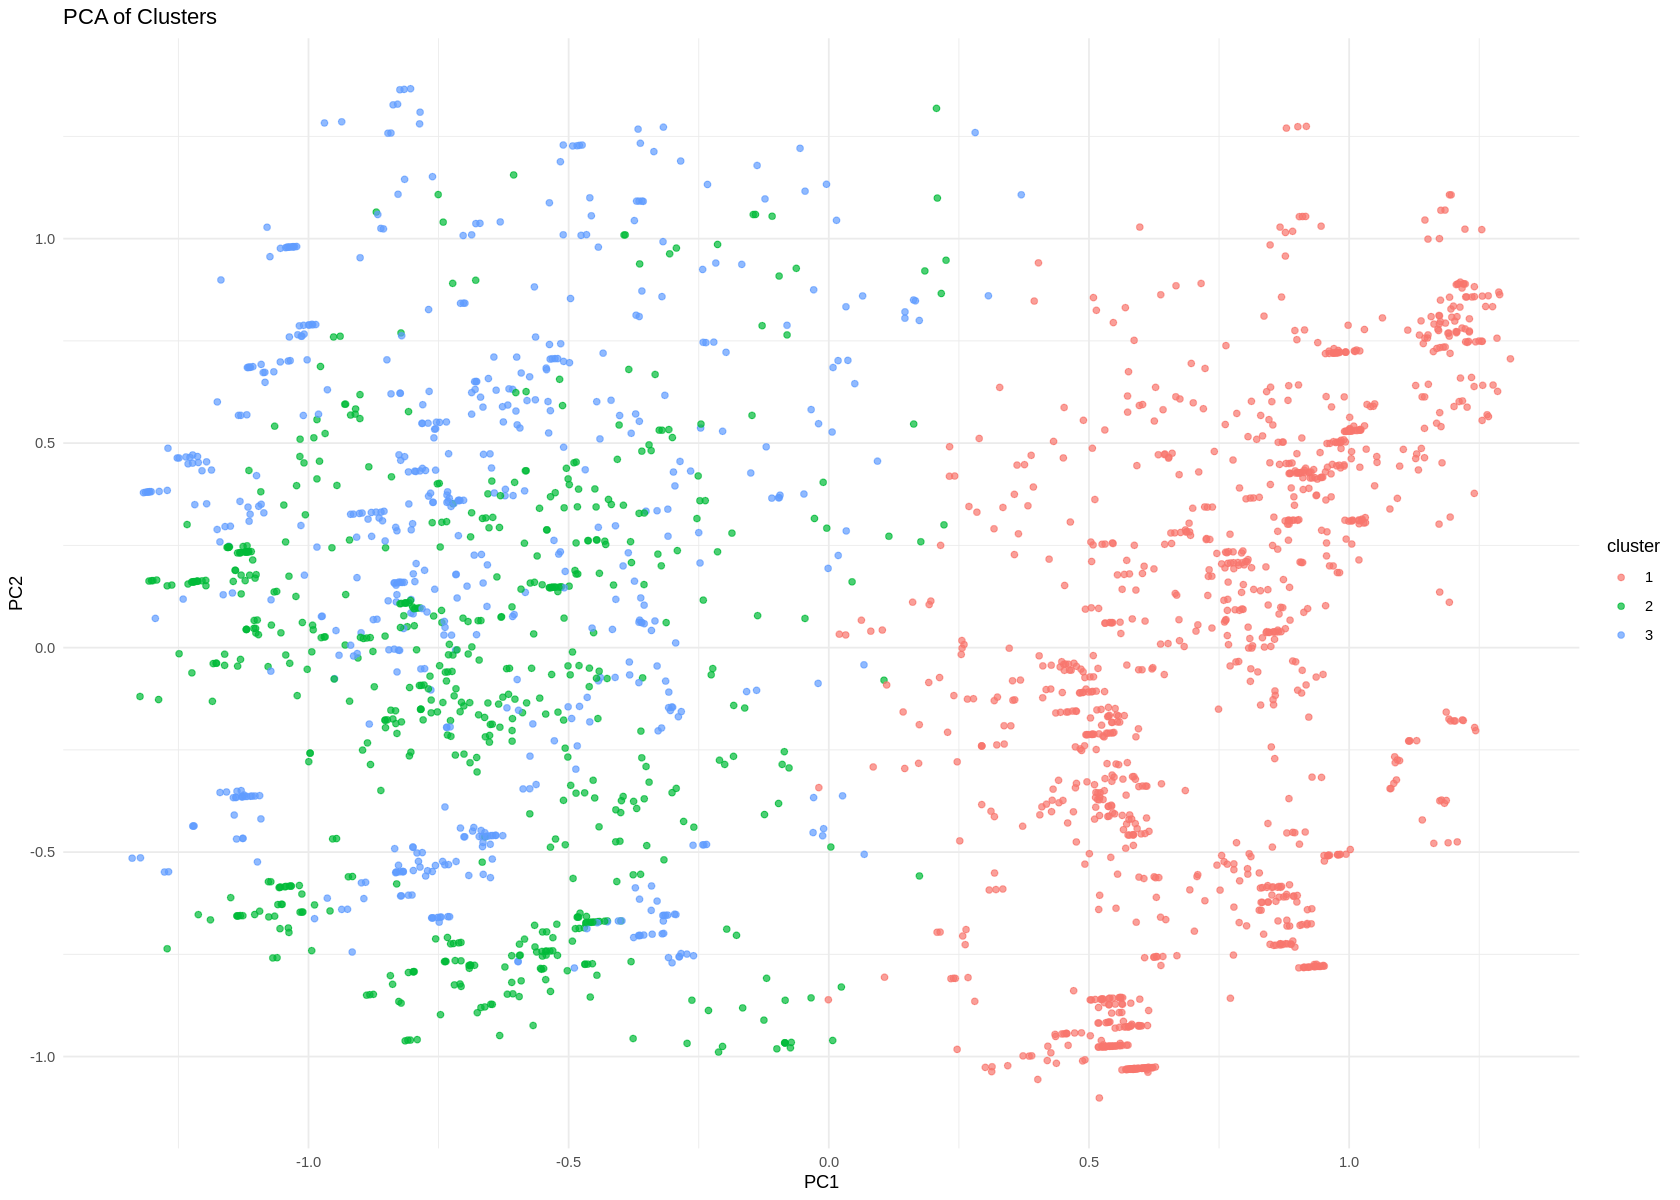

In [116]:
# Perform PCA
pca_result <- prcomp(df_preprocessed[, -ncol(df_preprocessed)])
df_pca <- data.frame(pca_result$x, cluster = as.factor(df_preprocessed$cluster))


# Plotting the PCA results using ggplot2
pca_plot <- ggplot(df_pca, aes(PC1, PC2, color = cluster)) +
  geom_point(alpha = 0.7) +
  ggtitle('PCA of Clusters') +
  theme_minimal()

print(pca_plot)

In [117]:
kmeans_result$tot.withinss

[1] 7394.115

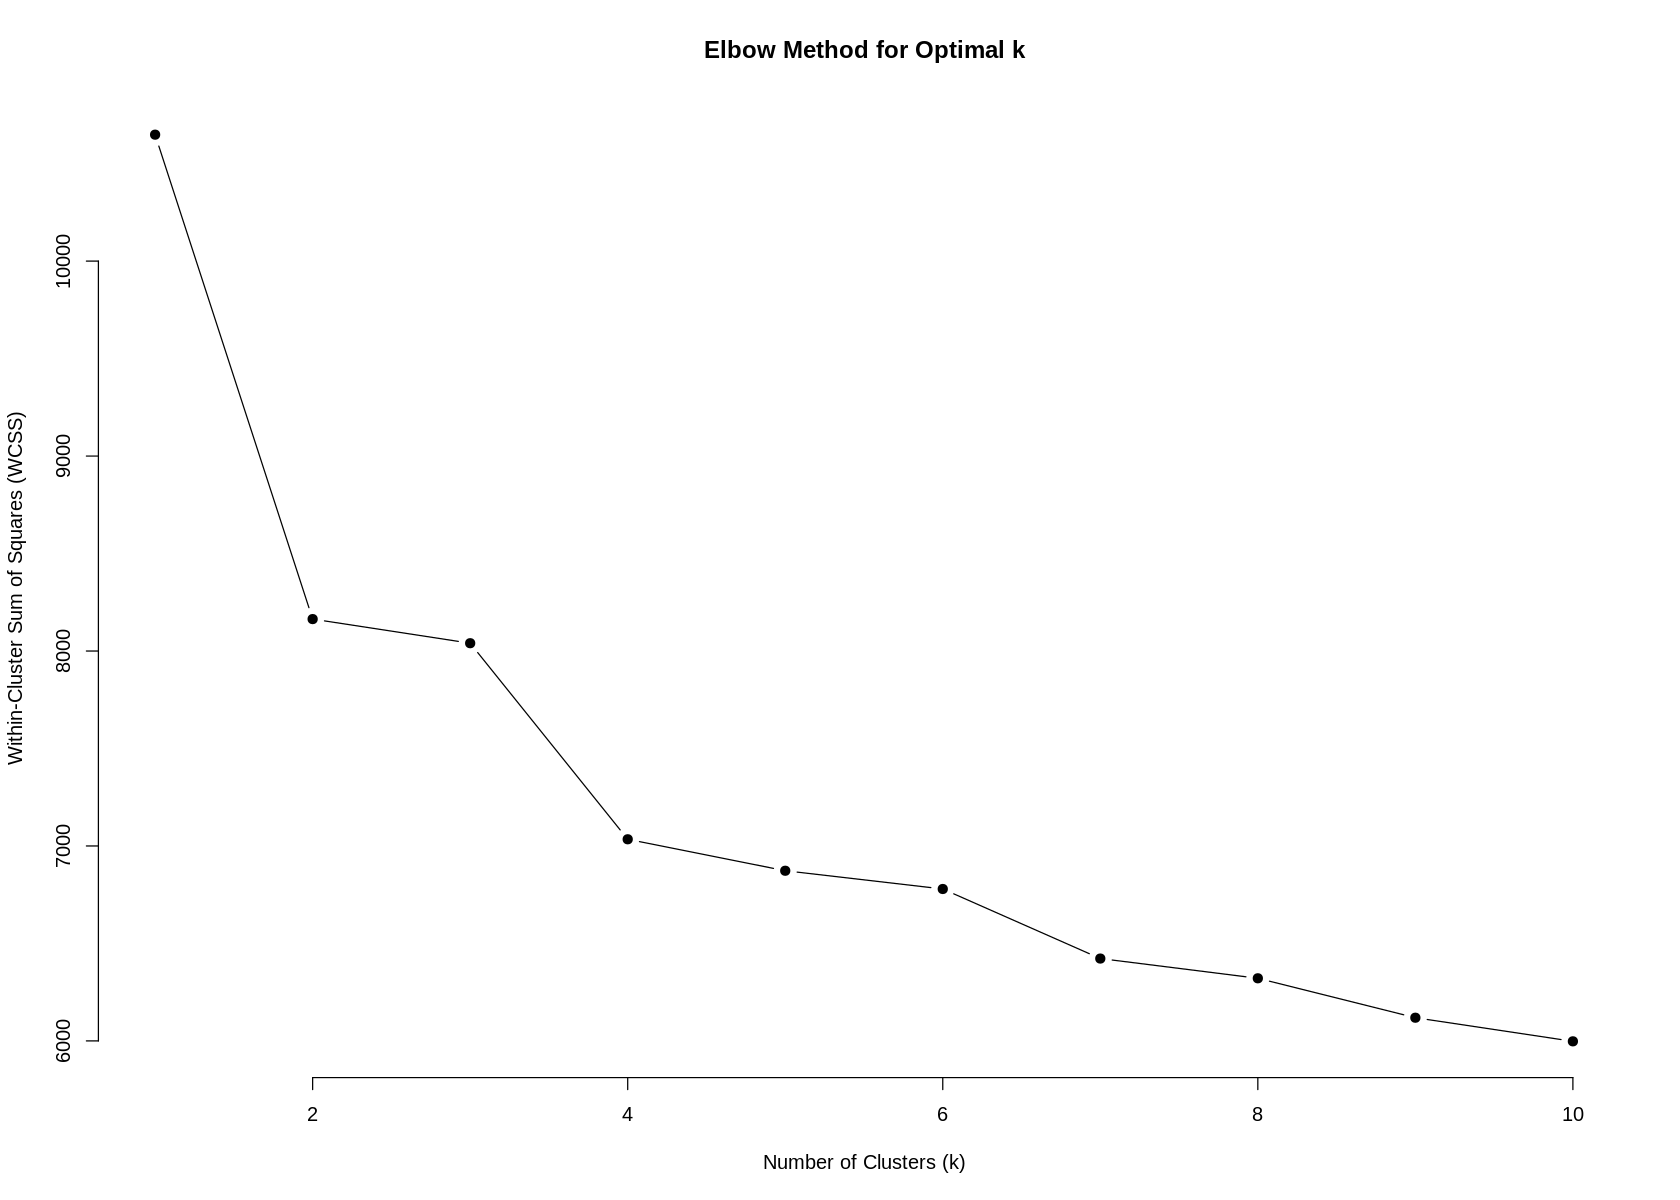

In [118]:
# Fit k-means clustering models for a range of k values
wcss <- vector()
for (i in 1:10) {
  kmeans_model <- kmeans(df_preprocessed, centers = i)
  wcss[i] <- kmeans_model$tot.withinss
}

# Plot the elbow curve
plot(1:10, wcss, type = "b", pch = 19, frame = FALSE,
     xlab = "Number of Clusters (k)", ylab = "Within-Cluster Sum of Squares (WCSS)",
     main = "Elbow Method for Optimal k")

In [119]:
k <- 4

set.seed(1) # Setting seed for reproducibility
kmeans_result <- kmeans(df_preprocessed, centers = k, nstart = 10)
df_preprocessed$cluster <- kmeans_result$cluster

head(df_preprocessed)

,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_5th-6th,education_7th-8th,education_9th,education_10th,⋯,native-country_Vietnam,native-country_Yugoslavia,income_>50K,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,cluster
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0.05479452,0.10961922,0.6666667,0,0.4107692,0.2886598,3
2,0,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0.09589041,0.07576284,0.8000000,0,0.0000000,0.3917526,1
3,0,1,0,0,0,0,0,0,0,1,⋯,0,0,0,0.21917808,0.14045160,0.3333333,0,0.0000000,0.2371134,1
4,0,0,1,0,0,0,0,0,0,0,⋯,0,0,1,0.34246575,0.22467205,0.8000000,0,0.0000000,0.4432990,2
5,0,1,0,0,0,0,0,0,0,0,⋯,0,0,1,0.47945205,0.08587033,0.7333333,0,0.0000000,0.3917526,2
6,0,0,1,0,0,0,0,0,0,0,⋯,0,0,0,0.13698630,0.06444302,0.8000000,0,0.0000000,0.3917526,1


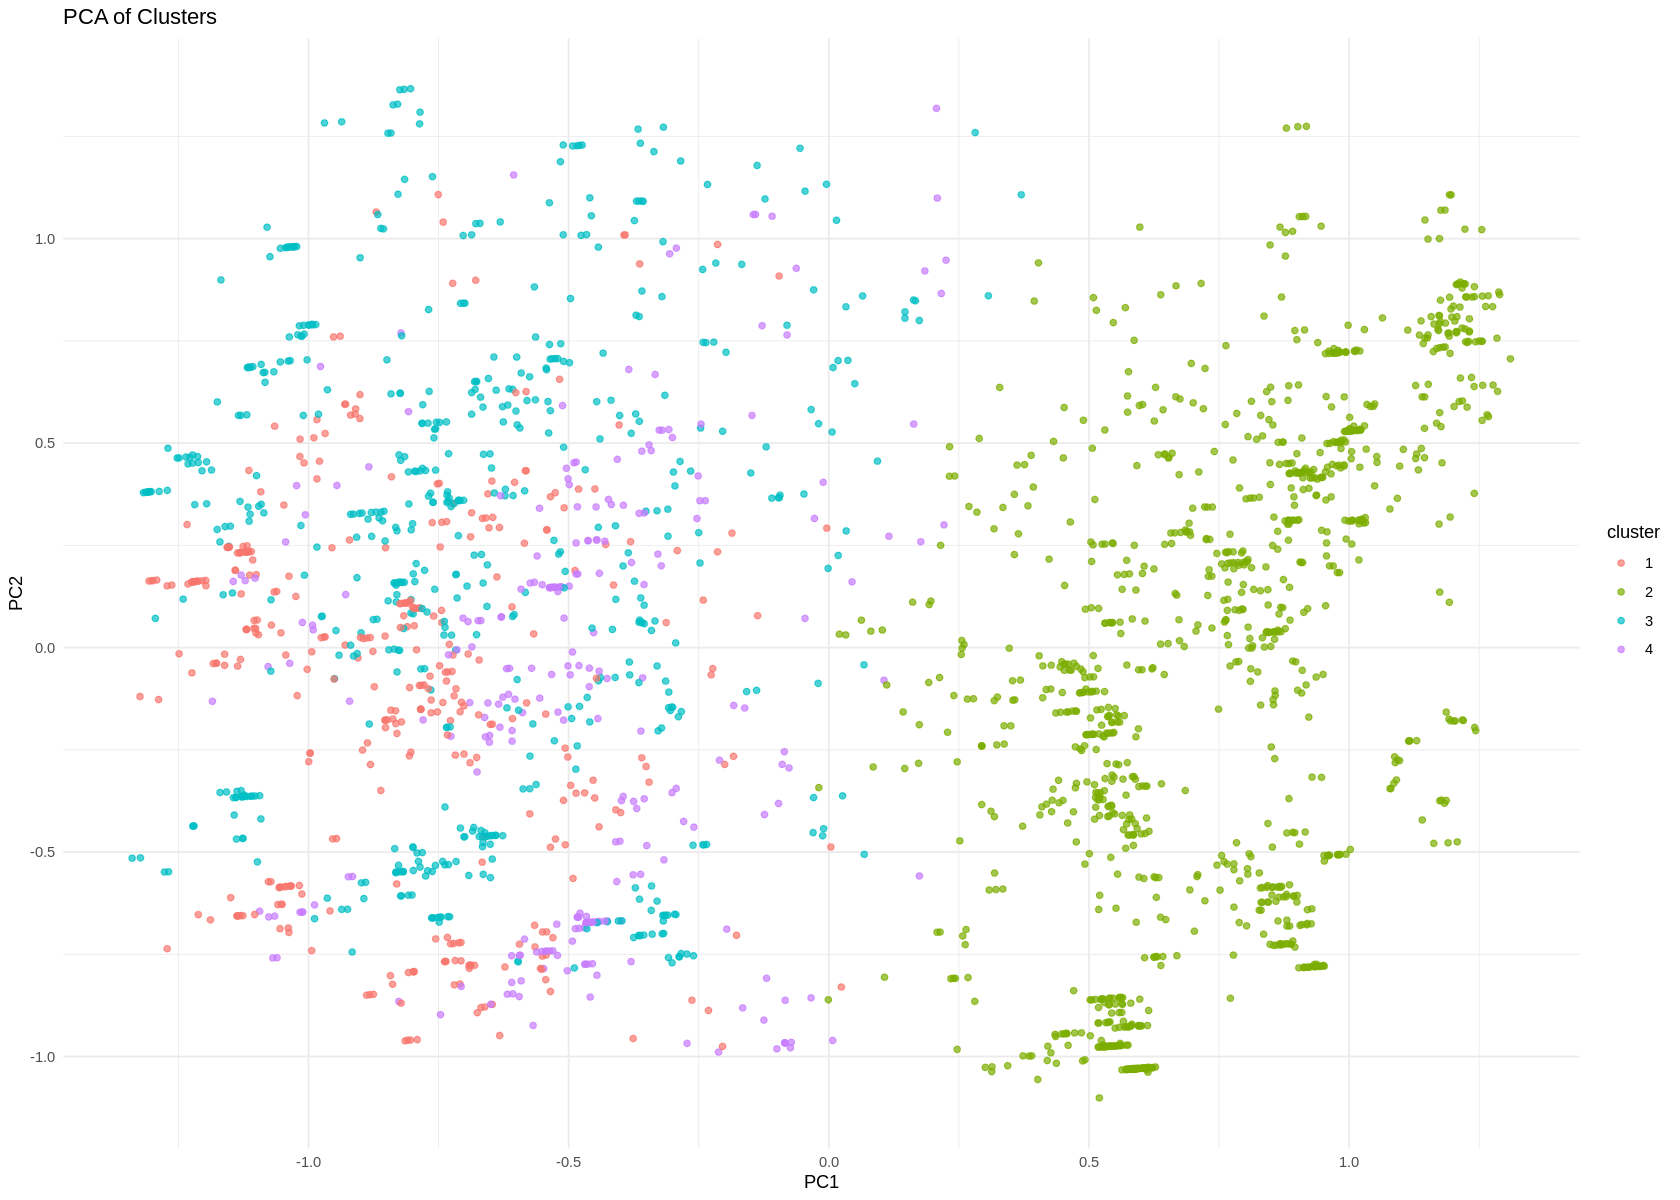

In [120]:
# Perform PCA
pca_result <- prcomp(df_preprocessed[, -ncol(df_preprocessed)])
df_pca <- data.frame(pca_result$x, cluster = as.factor(df_preprocessed$cluster))

# Plotting the PCA results using ggplot2
pca_plot <- ggplot(df_pca, aes(PC1, PC2, color = cluster)) +
  geom_point(alpha = 0.7) +
  ggtitle('PCA of Clusters') +
  theme_minimal()

print(pca_plot)

In [121]:
kmeans_result$tot.withinss

[1] 7034.327

In [122]:
dist_matrix <- dist(df_preprocessed, method = "euclidean")

silhouette_score <- silhouette(df_preprocessed$cluster, dist_matrix)
summary(silhouette_score)

Silhouette of 2303 units in 4 clusters from silhouette.default(x = df_preprocessed$cluster, dist = dist_matrix) :
 Cluster sizes and average silhouette widths:
      363      1092       595       253 
0.2596838 0.2120518 0.1995401 0.1869307 
Individual silhouette widths:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.04433 0.18151 0.21688 0.21357 0.24639 0.36440 

## Hierarchical clustering

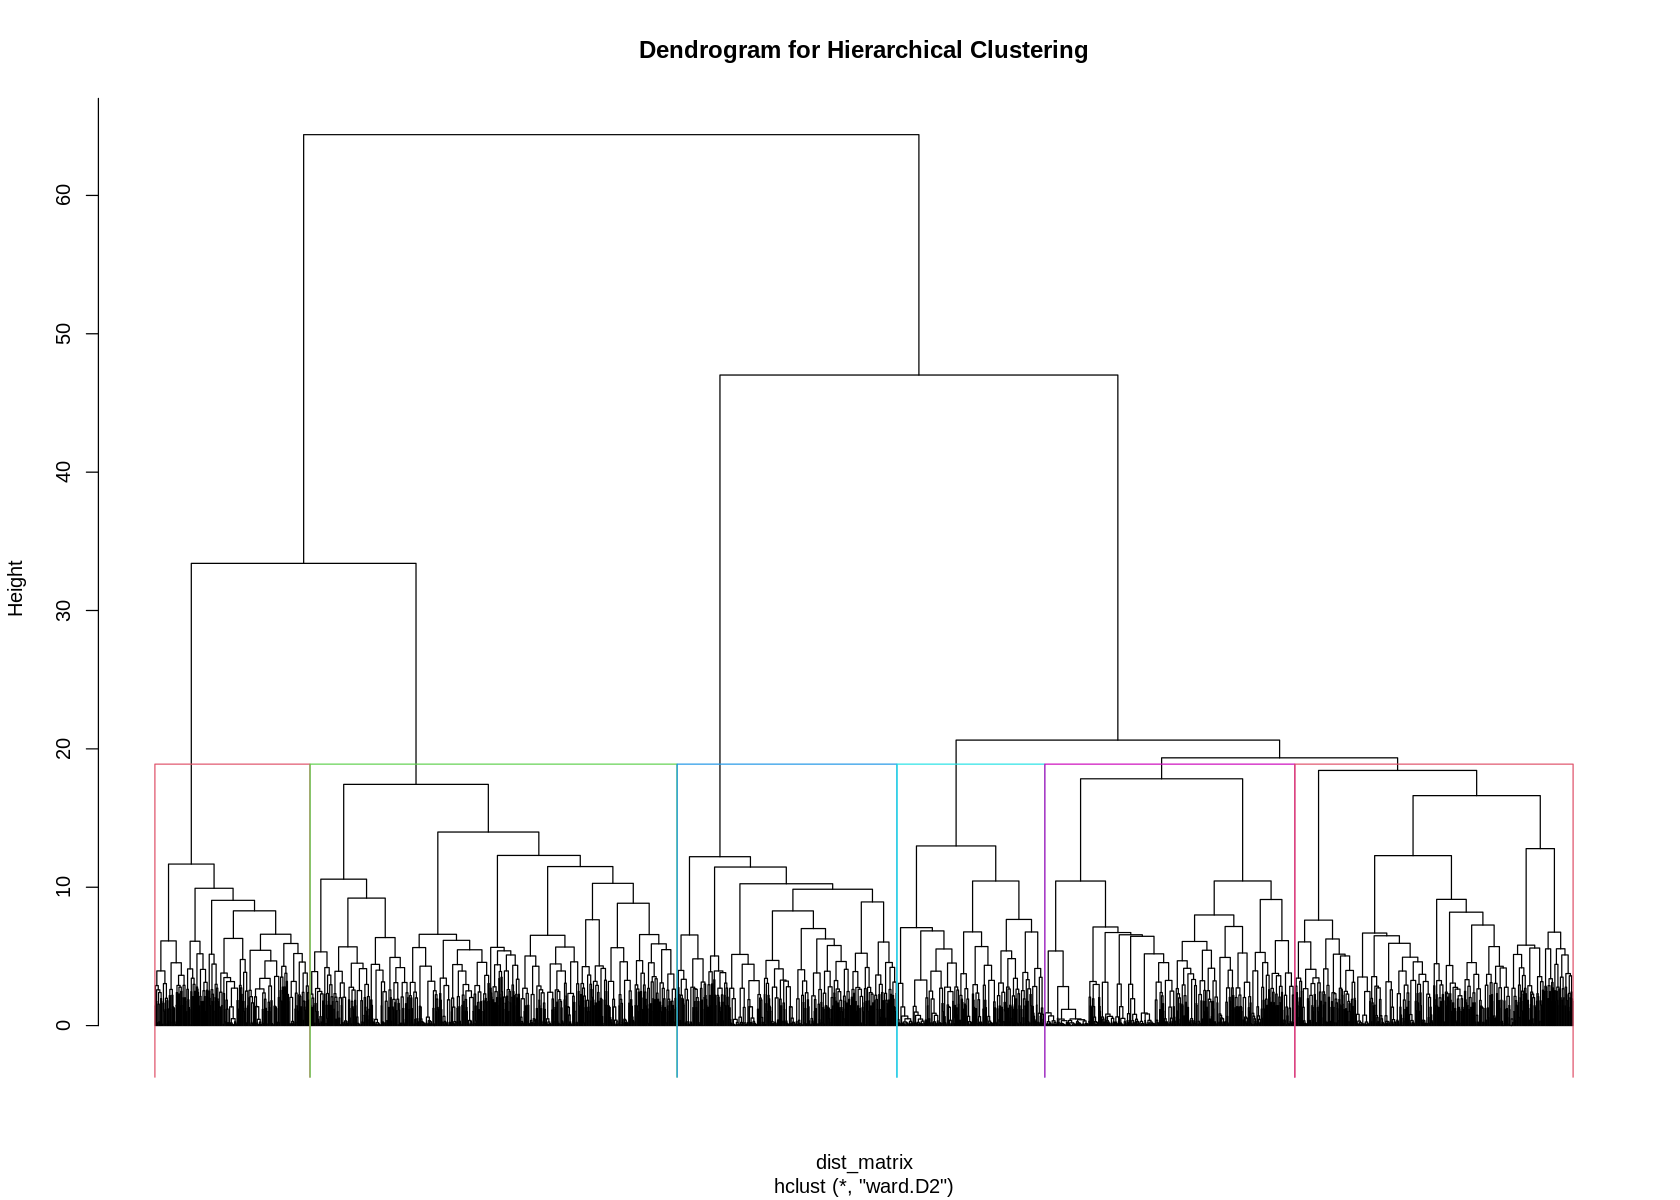

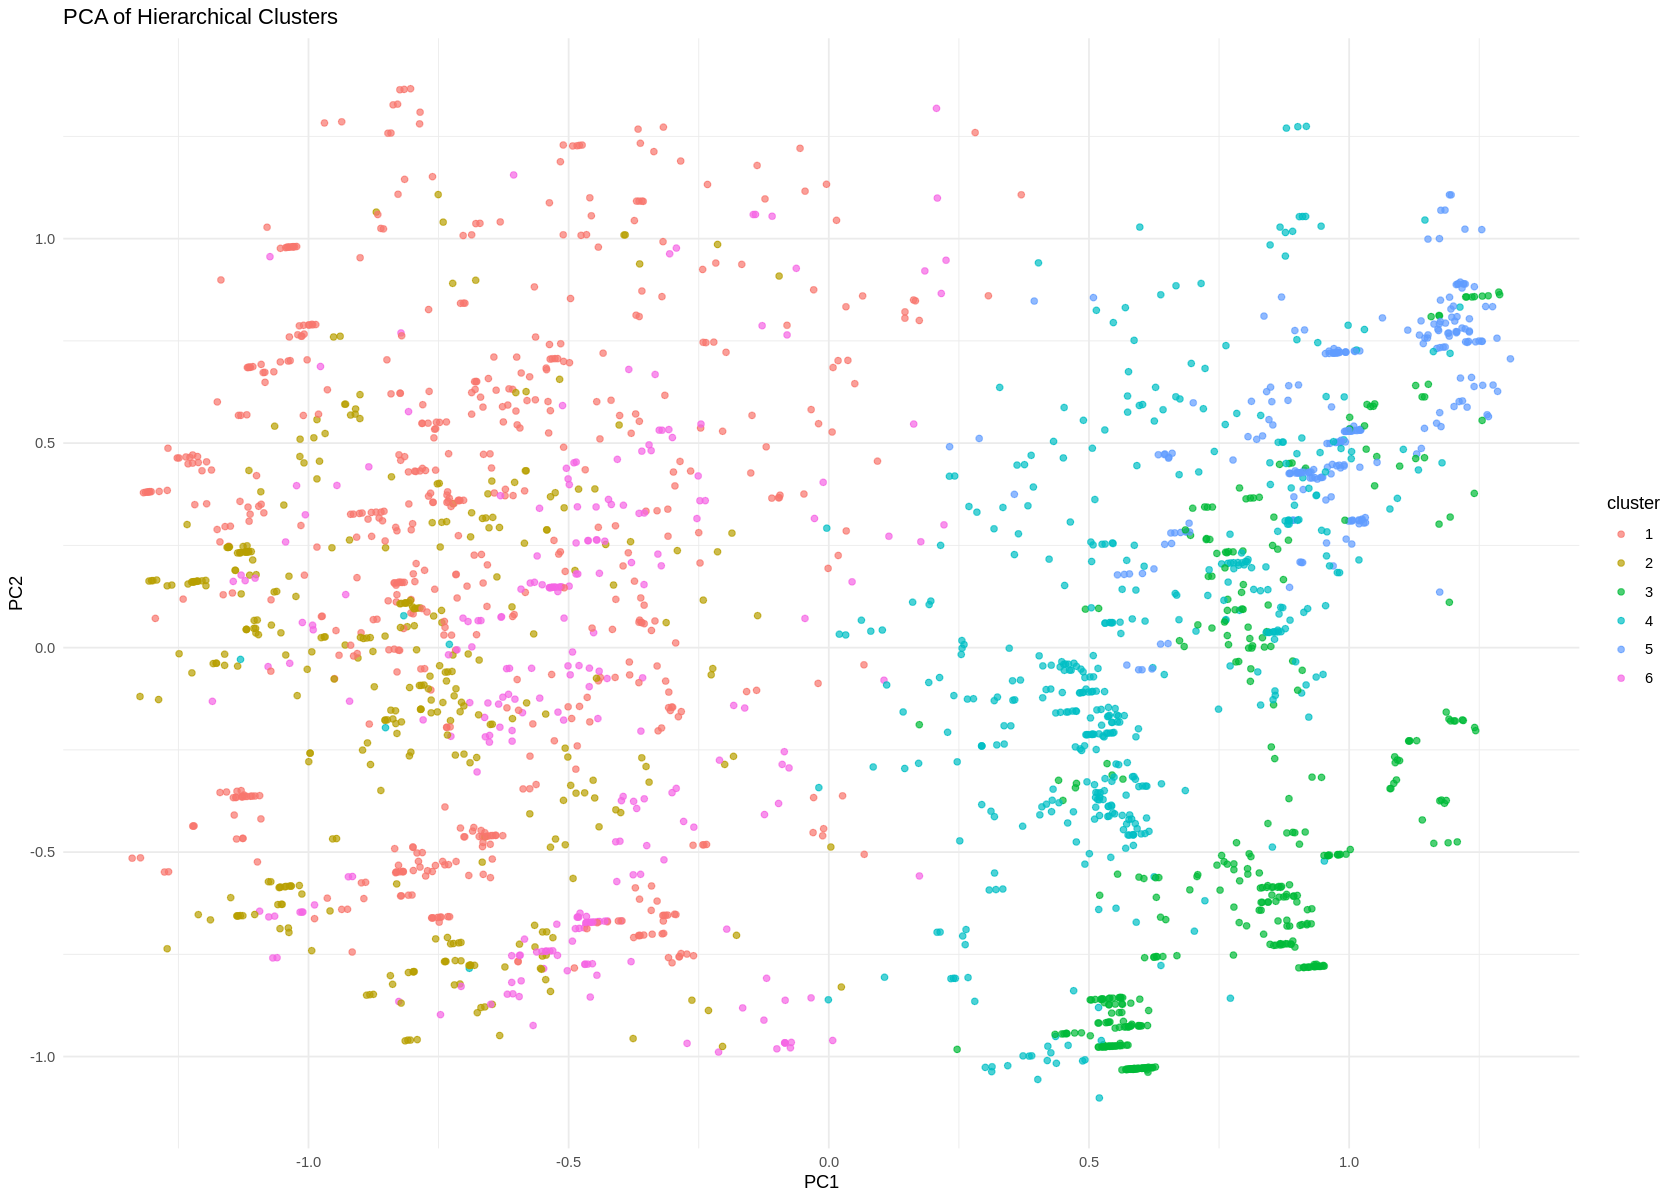

In [125]:
# Hierarchical Clustering
hc <- hclust(dist_matrix, method = "ward.D2")
plot(hc, labels = FALSE, hang = -1, main = "Dendrogram for Hierarchical Clustering")
rect.hclust(hc, k = 6, border = 2:6)

# Cut the tree into clusters
clusters_hc <- cutree(hc, k = 6)
df_preprocessed$cluster_hc <- clusters_hc

# PCA plot for Hierarchical Clustering
df_pca_hc <- data.frame(pca_result$x, cluster = as.factor(df_preprocessed$cluster_hc))
pca_plot_hc <- ggplot(df_pca_hc, aes(PC1, PC2, color = cluster)) +
  geom_point(alpha = 0.7) +
  ggtitle('PCA of Hierarchical Clusters') +
  theme_minimal()

print(pca_plot_hc)

In [126]:
silhouette_score <- silhouette(df_preprocessed$cluster_hc, dist_matrix)
summary(silhouette_score)

Silhouette of 2303 units in 6 clusters from silhouette.default(x = df_preprocessed$cluster_hc, dist = dist_matrix) :
 Cluster sizes and average silhouette widths:
        596         357         406         452         240         252 
 0.17379902  0.23577920  0.15152226 -0.04359602  0.14869155  0.18461176 
Individual silhouette widths:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.19153  0.07613  0.15861  0.13538  0.21948  0.35378 

## Model-based clustering

In [127]:
# Perform model-based clustering with Mclust on PCA result
mclust_result <- Mclust(pca_result$x, modelNames = "EII", G = 4:6)

# Extract clustering results
df_preprocessed$cluster_mclust <- mclust_result$classification

# Print summary of clustering results
summary(mclust_result)

---------------------------------------------------- 
Gaussian finite mixture model fitted by EM algorithm 
---------------------------------------------------- 

Mclust EII (spherical, equal volume) model with 6 components: 

 log-likelihood    n  df      BIC      ICL
       54629.15 2303 552 104984.7 104931.2

Clustering table:
   1    2    3    4    5    6 
1052  347  120   76  348  360 

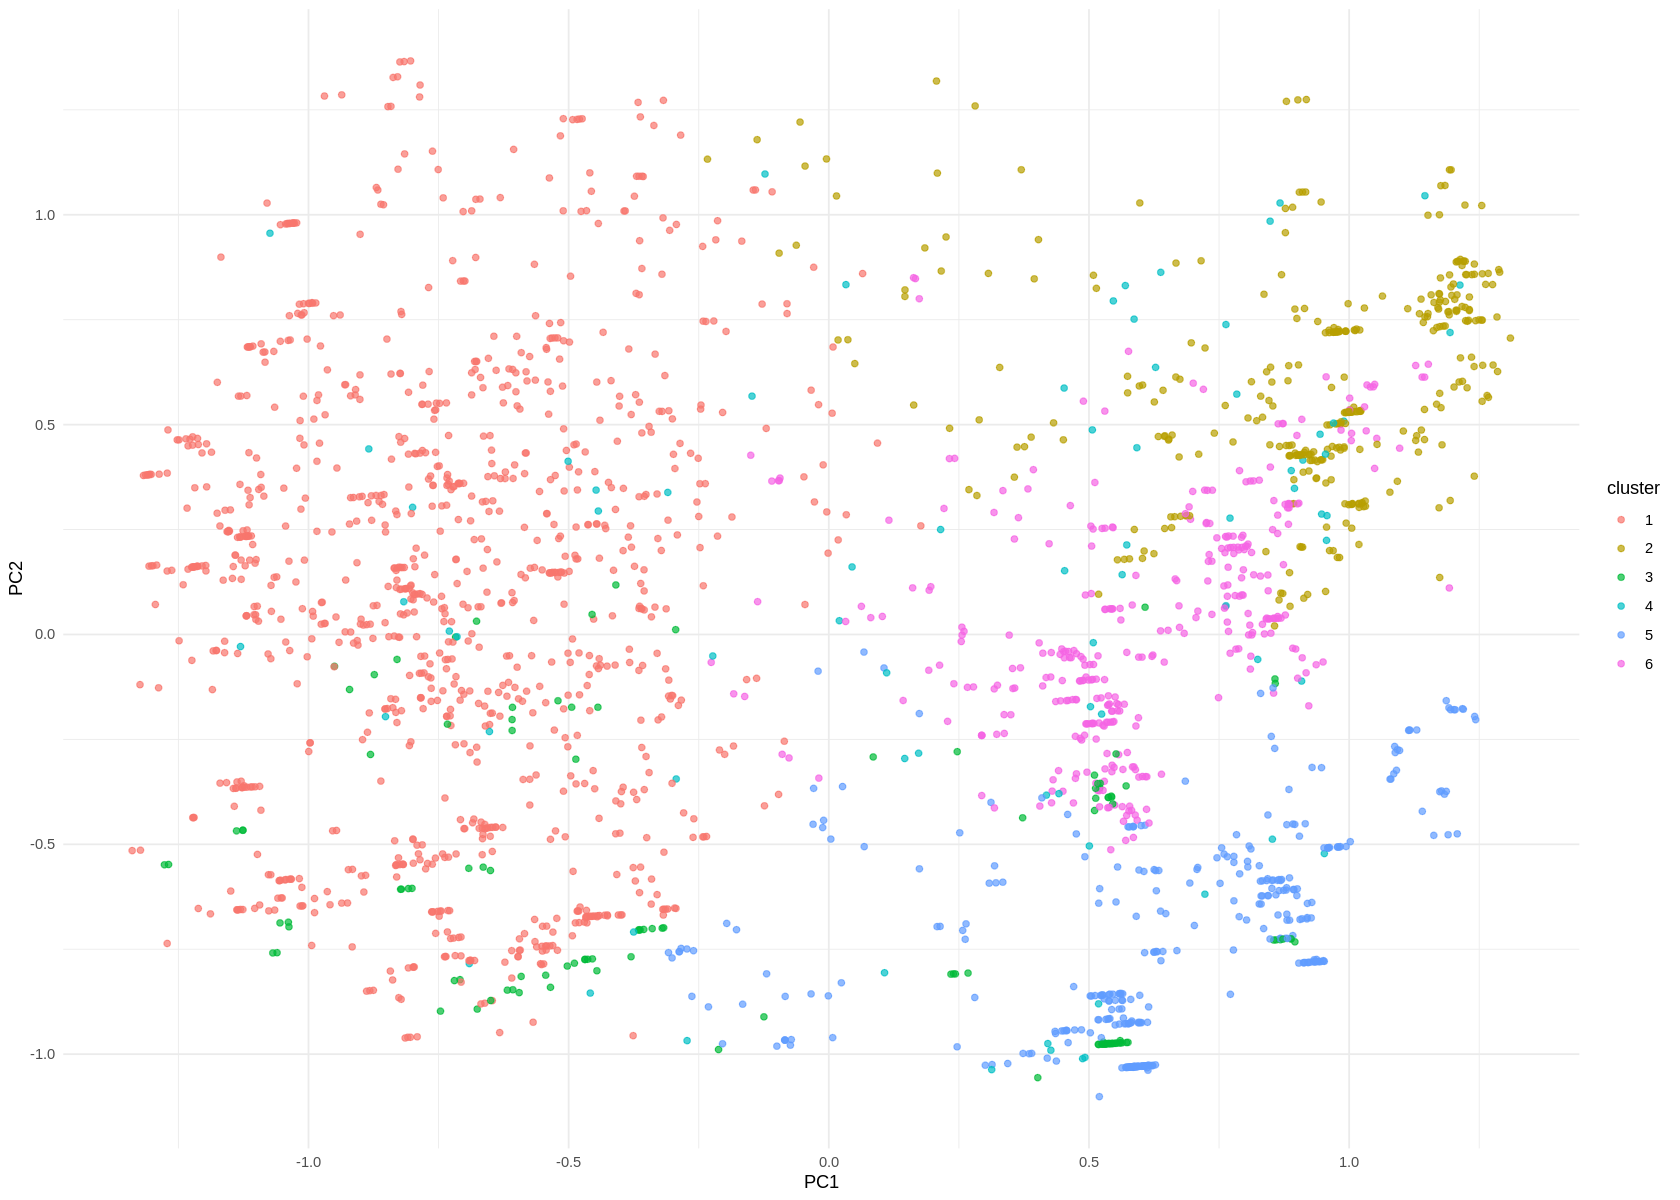

In [128]:
# Create a dataframe for PCA results with cluster labels
pca_df <- data.frame(pca_result$x)
df_pca_mclust <- data.frame(pca_df, cluster = as.factor(df_preprocessed$cluster_mclust))

# Plot the PCA results using ggplot2
pca_plot_mclust <- ggplot(df_pca_mclust, aes(PC1, PC2, color = cluster)) +
  geom_point(alpha = 0.7) +
  theme_minimal()

print(pca_plot_mclust)

In [129]:
silhouette_score <- silhouette(df_preprocessed$cluster_mclust, dist_matrix)
summary(silhouette_score)

Silhouette of 2303 units in 6 clusters from silhouette.default(x = df_preprocessed$cluster_mclust, dist = dist_matrix) :
 Cluster sizes and average silhouette widths:
       1052         347         120          76         348         360 
-0.01061915  0.10996849  0.07955467 -0.02180085  0.17163417  0.06846525 
Individual silhouette widths:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.16001 -0.01320  0.03584  0.05178  0.11433  0.27629 

In [136]:
# Perform model-based clustering with Mclust on PCA result
mclust_result <- Mclust(pca_result$x, modelNames = "EII", G = 2:4)

# Extract clustering results
df_preprocessed$cluster_mclust <- mclust_result$classification

# Print summary of clustering results
summary(mclust_result)

---------------------------------------------------- 
Gaussian finite mixture model fitted by EM algorithm 
---------------------------------------------------- 

Mclust EII (spherical, equal volume) model with 4 components: 

 log-likelihood    n  df      BIC      ICL
       52946.25 2303 368 103043.5 102994.9

Clustering table:
  1   2   3   4 
245 653 972 433 

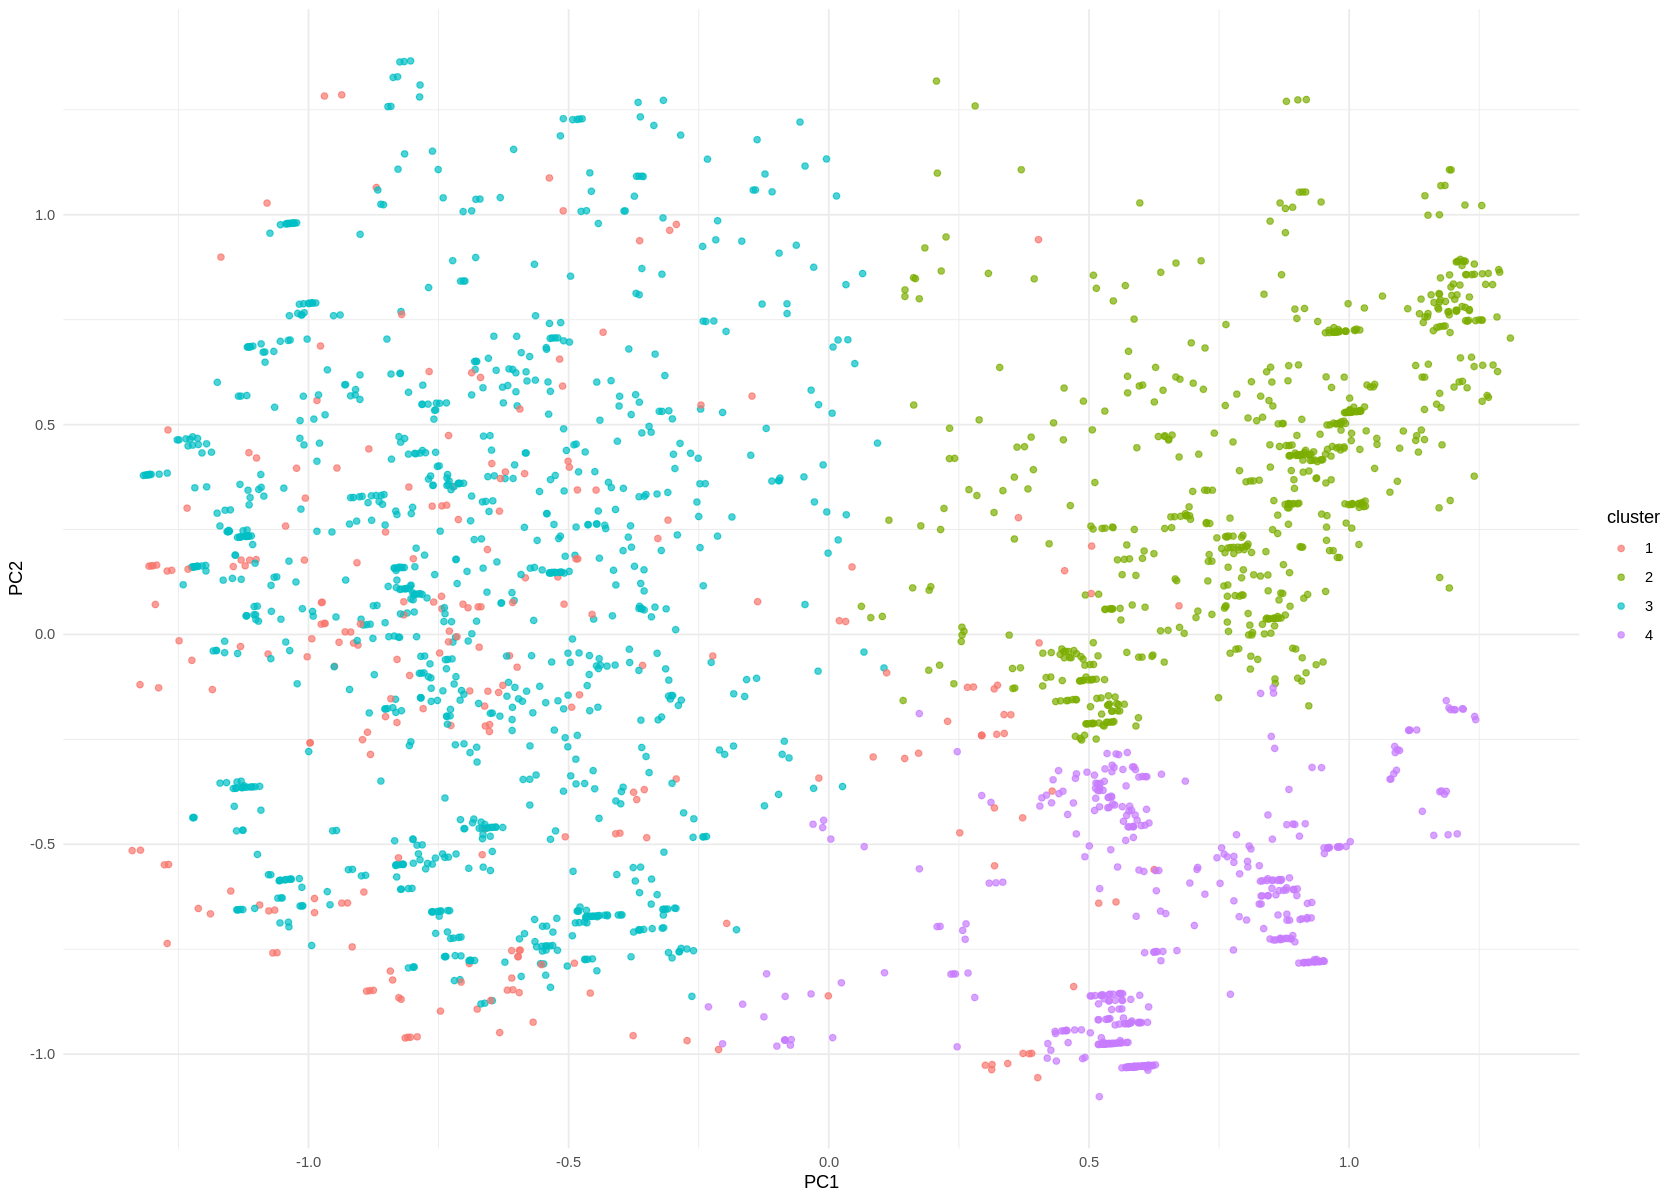

In [137]:
# Create a dataframe for PCA results with cluster labels
pca_df <- data.frame(pca_result$x)
df_pca_mclust <- data.frame(pca_df, cluster = as.factor(df_preprocessed$cluster_mclust))

# Plot the PCA results using ggplot2
pca_plot_mclust <- ggplot(df_pca_mclust, aes(PC1, PC2, color = cluster)) +
  geom_point(alpha = 0.7) +
  theme_minimal()

print(pca_plot_mclust)

In [138]:
silhouette_score <- silhouette(df_preprocessed$cluster_mclust, dist_matrix)
summary(silhouette_score)

Silhouette of 2303 units in 4 clusters from silhouette.default(x = df_preprocessed$cluster_mclust, dist = dist_matrix) :
 Cluster sizes and average silhouette widths:
       245        653        972        433 
0.00736720 0.03942931 0.04456477 0.18147718 
Individual silhouette widths:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.20185  0.01230  0.05955  0.06489  0.10902  0.31922 

In [139]:
# Perform model-based clustering with Mclust on PCA result
mclust_result <- Mclust(pca_result$x, modelNames = "VII", G = 2:4)

# Extract clustering results
df_preprocessed$cluster_mclust <- mclust_result$classification

# Print summary of clustering results
summary(mclust_result)

---------------------------------------------------- 
Gaussian finite mixture model fitted by EM algorithm 
---------------------------------------------------- 

Mclust VII (spherical, varying volume) model with 4 components: 

 log-likelihood    n  df      BIC      ICL
       52146.25 2303 371 101420.2 101349.9

Clustering table:
  1   2   3   4 
909 514 690 190 

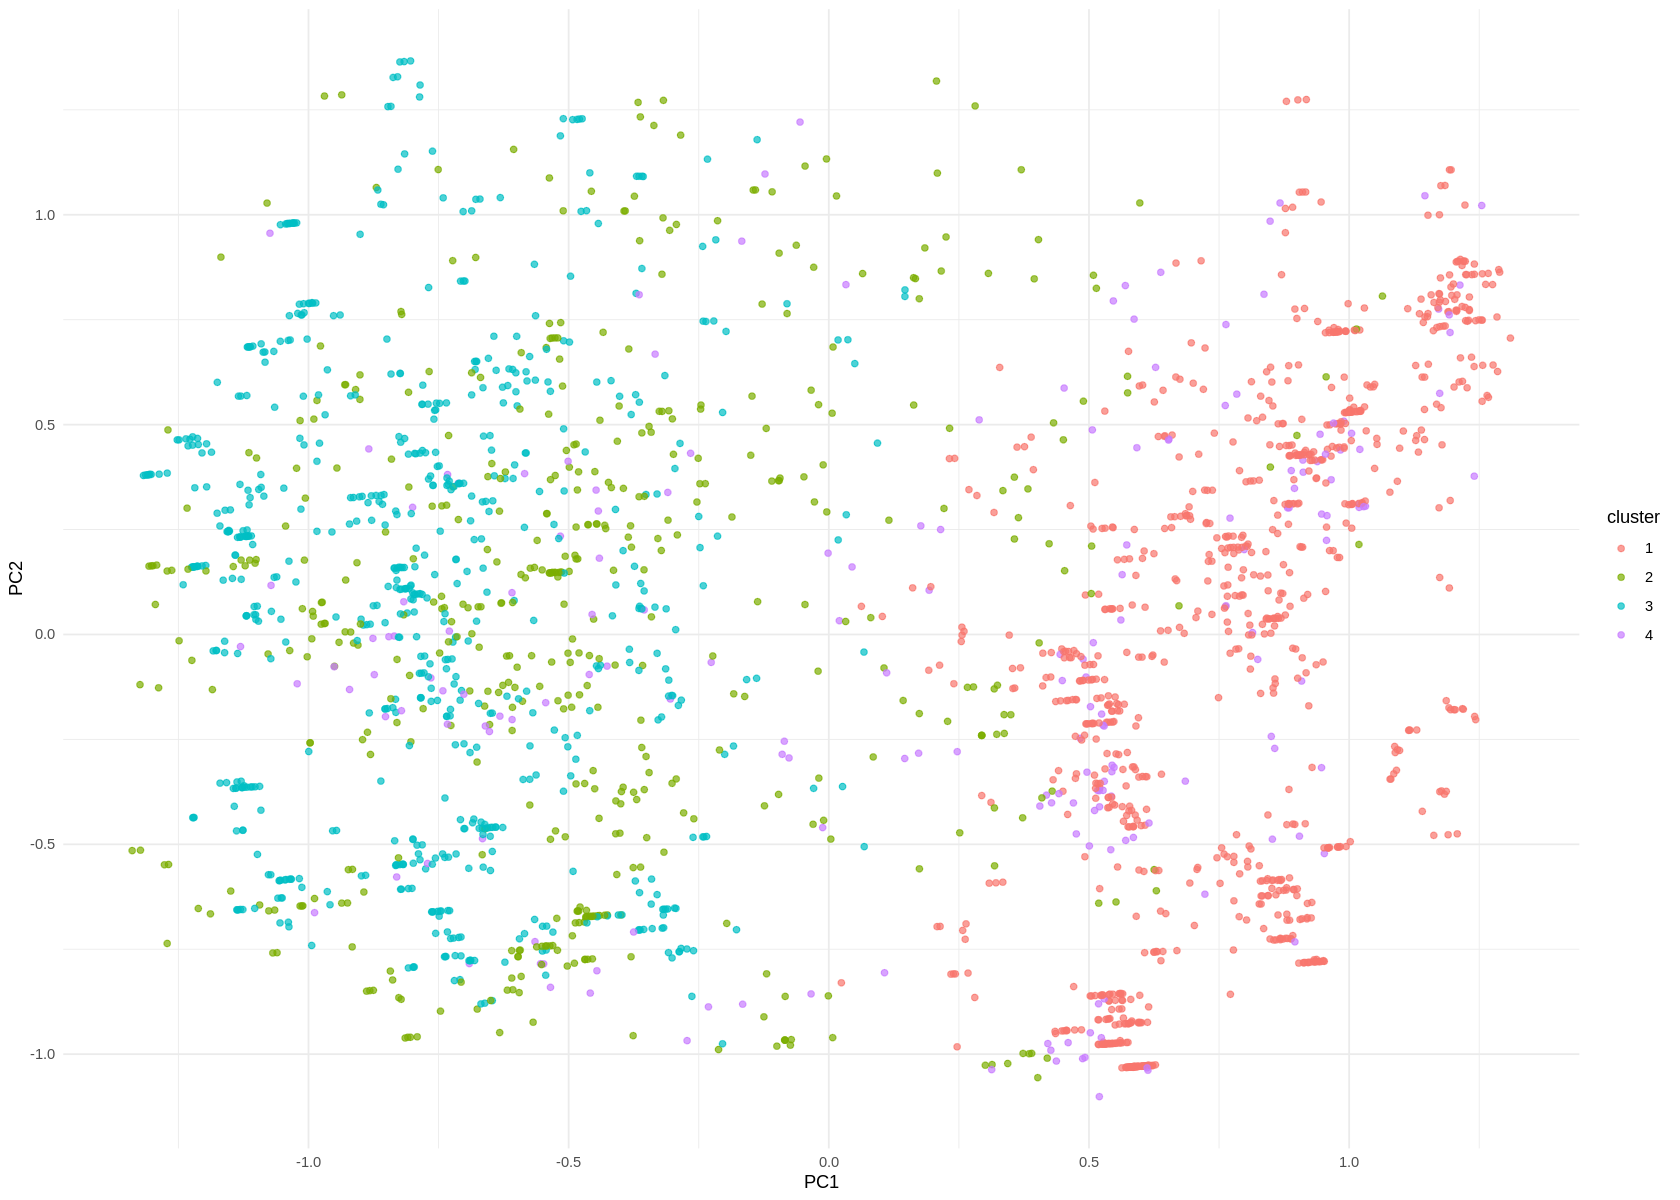

In [140]:
# Create a dataframe for PCA results with cluster labels
pca_df <- data.frame(pca_result$x)
df_pca_mclust <- data.frame(pca_df, cluster = as.factor(df_preprocessed$cluster_mclust))

# Plot the PCA results using ggplot2
pca_plot_mclust <- ggplot(df_pca_mclust, aes(PC1, PC2, color = cluster)) +
  geom_point(alpha = 0.7) +
  theme_minimal()

print(pca_plot_mclust)

In [141]:
silhouette_score <- silhouette(df_preprocessed$cluster_mclust, dist_matrix)
summary(silhouette_score)

Silhouette of 2303 units in 4 clusters from silhouette.default(x = df_preprocessed$cluster_mclust, dist = dist_matrix) :
 Cluster sizes and average silhouette widths:
        909         514         690         190 
 0.24034469 -0.03672368  0.11319599 -0.07775403 
Individual silhouette widths:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.2105  0.0323  0.1407  0.1142  0.2343  0.3168 